In [1]:
import sys
import os

# Add root directory of rhe project into sys.path
sys.path.append(os.path.abspath(os.path.join("..")))

## **0. Libraries**

In [2]:
from src.visualization import display_images_and_targets
from src.dataset import LicensePlateDataset
from src.utils import print_tree
from src.config import Config

import torch
import os
import warnings
import albumentations as A

from torchvision import transforms
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")

## **1. Physical devices**

In [3]:
# Check GPU
print(f'Does the device have a GPU? {torch.cuda.is_available()}')
print(f'The device has {torch.cuda.device_count()} GPU(s)')
for i in range(torch.cuda.device_count()):
    print(f'The GPU(s) name of device is: {torch.cuda.get_device_name(i)}')

Does the device have a GPU? False
The device has 0 GPU(s)


In [4]:
num_workers = os.cpu_count()
print(f'The number of cores of your CPU: {num_workers}')

The number of cores of your CPU: 8


## **2. Dataset**

In [5]:
# Get the list of file paths in each folder
file_pathes = {}
for dir_name in os.listdir(Config.PROCESSED_DATA_DIR):
    dir_path = os.path.join(Config.PROCESSED_DATA_DIR, dir_name)
    file_pathes[dir_name] = []
    for filename in os.listdir(dir_path):
        file_pathes[dir_name].append(os.path.join(dir_path, filename))

In [6]:
# Directory tree of processed data
print_tree(Config.PROCESSED_DATA_DIR)

[DIR] processed
    [DIR] test
        [FILE] xemay1817_jpg.rf.119f2c447b36c4a29c10f0ef8e90e019.xml
        [FILE] CarLongPlateGen2231_jpg.rf.09a6ae0129bd4a3ccac80d66ba4e4b95.xml
        [FILE] xemay246_jpg.rf.530bba55def20c3ce976703557b39b7b.xml
        [FILE] xemay66_jpg.rf.a9939bfd9034efff251c176215d259cc.jpg
        [FILE] CarLongPlateGen2960_jpg.rf.bda1b9f4642a8866ed162c2edfbe3b94.xml
        [...]
    [DIR] valid
        [FILE] CarLongPlateGen1530_jpg.rf.3289b63b8aff3d0c30701736cc0d7712.jpg
        [FILE] CarLongPlateGen1708_jpg.rf.2562fda9da07faf37e8f1cfad4393f9f.xml
        [FILE] xemay397_jpg.rf.5b5289344b4ebe46f7c772ac2fb435e3.jpg
        [FILE] CarLongPlateGen1809_jpg.rf.c451d9563fb97938eaf545a70ff4c457.jpg
        [FILE] CarLongPlateGen86_jpg.rf.6aa8cb57bb3b078e4f1a23b0efe49706.jpg
        [...]
    [DIR] train
        [FILE] CarLongPlateGen2707_jpg.rf.92e2bb3a0499e548f3bc2e54cc4ce299.xml
        [FILE] 003df8cf2effae50_jpg.rf.85b92c041e14d9bcf4ed1fd70de9661f.jpg
        [F

## **3. Data preprocessing**

After downloading the dataset and storing it locally, now we will move on to the step of reading the images and getting the labels of each image based on the filename of each image and XML file, and for each folder, we will also be able to split the dataset into 3 separate datasets, namely `training set`, `validation set` and `test set`.

We will initialize the dataset by using the **Dataset** class of **Pytorch**, which is a special class that allows us to store the entire image in a variable without worrying about memory impact. **Dataset** helps load data in a **Lazy Loading** style (loading data when needed), saving memory and processing large data sets without having to load the entire data set into memory. When combined with the **DataLoader** class of **PyTorch**, Dataset allows us to automatically split the data into small **batches** and can **shuffle** the data to ensure that the samples are trained randomly. This is important to minimize overfitting and improve training efficiency.

<div align="center">
    <img
        src="../assets/lazy_loading.png"    
        alt=""
        width="700"
    />
</div>

Based on the image above, we will mark from (1) to (4) for each image for easy description. Suppose we have `N` images locally (1), and the storage method of **Dataset** (2) is to store the entire path of `N` images of (1) and divide them into batches, suppose each batch will be 2 images, and every time the model or user calls the 2nd batch in `N` images (1), **Dataset** will use the **Lazy Loading** mechanism (3) and only load 2 images in the exact 2nd batch from (1) into memory and send to (4) - this can be the model calling or the user calling. Therefore, we can preserve the original data and keep functions such as batching, mixing, ...

In [ ]:
# Transform images
train_transforms = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), 
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3), 
    A.GaussNoise(std_range=(0.1, 0.2), per_channel=False, p=0.3), 
    A.MotionBlur(blur_limit=3, p=0.2), 
    A.RandomFog(fog_coef_range=(0.1, 0.3), alpha_coef=0.08, p=0.1), 
    A.Rotate(limit=5, p=0.3), 
    A.Resize(height=Config.IMAGE_SIZE[0], width=Config.IMAGE_SIZE[1]), 
    A.Normalize(mean=Config.MEAN_NORMALIZATION, std=Config.STD_NORMALIZATION), 
    A.ToTensorV2(), 
], bbox_params=A.BboxParams(
    format="pascal_voc", 
    label_fields=["labels"], 
    min_visibility=0.3
))

val_transforms = A.Compose([
    A.Resize(height=Config.IMAGE_SIZE[0], width=Config.IMAGE_SIZE[1]), 
    A.Normalize(mean=Config.MEAN_NORMALIZATION, std=Config.STD_NORMALIZATION), 
    A.ToTensorV2(), 
], bbox_params=A.BboxParams(
    format="pascal_voc", 
    label_fields=["labels"]
))

In [ ]:
# Declare dataset and dataloader
train_dataset = LicensePlateDataset(
    file_paths=file_pathes["train"], 
    transforms=train_transforms,
)
valid_dataset = LicensePlateDataset(
    file_paths=file_pathes["valid"], 
    transforms=val_transforms, 
)
test_dataset = LicensePlateDataset(
    file_paths=file_pathes["test"], 
)

For image problems, in addition to the pre-trained models provided by **Pytorch** through the **torchvision** module, the library also provides special classes combined with the **Dataset** class to help us preprocess image data while calling `__getitem__`, specifically the **Transform** class, this is a class that helps us make image features better through transformations such as image rotation, image normalization, image flipping, resizing,... To normalize, we just need to use the transformation `ToTensor()` of **Transform**, a library that will help us normalize and convert from **numpy** to **tensor**.

<div align="center">
    <img
        src="https://www.researchgate.net/publication/356632069/figure/fig3/AS:1095686288347139@1638243376533/Bounding-box-definition-in-the-image-coordinates-system.ppm"
        alt=""
        width="500"
    />
</div>

We can check the data folder and see that the images have been pre-processed by a third party, **Roboflow**, they have done some transformations like resizing all the images to `640x640x3`, rotating the images, removing white points, etc. Therefore, we don't need to do too much processing on this data anymore, what we need to do is resize the images to reduce the image size to speed up the training process and normalize the images to the range `[0, 1]`, this will avoid the problem of unit difference between pixels because each pixel of the image will have a value from `[0, 255]`, and normalization will also help the model converge faster and learn better. Based on the data labels are bounding boxes with range in image size, so we can also normalize these labels by taking the $x_{min},\ y_{min},\ x_{max},\ y_{max}$ points of the bounding box divided by the appropriate image size to bring this label to the range `[0, 1]`, for example

$$\frac{x_{min}}{width\ image}$$

and

$$\frac{y_{min}}{height\ image}$$

To convert back to the original value, we simply multiply back by the image size.

In [9]:
# A sample in training dataset
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -1.6727, -2.1179],
          [-1.9809, -1.3130, -2.1179,  ..., -1.5870, -2.1179, -1.2274],
          [-2.1179, -1.4672, -1.9980,  ..., -2.1179, -1.8953, -1.3987],
          ...,
          [-1.4500, -1.0390, -1.0219,  ..., -2.1179, -1.5357, -1.1589],
          [-2.1179, -2.1179, -2.1179,  ..., -1.8782, -2.1179, -2.0152],
          [-2.1179, -2.1179, -1.6555,  ..., -1.6555, -2.1179, -2.1008]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -1.5805, -2.0357],
          [-1.8957, -1.2129, -2.0357,  ..., -1.4930, -2.0357, -1.1253],
          [-2.0357, -1.3704, -1.9132,  ..., -2.0357, -1.8081, -1.3004],
          ...,
          [-1.3529, -0.9328, -0.8803,  ..., -2.0357, -1.4405, -1.0553],
          [-2.0357, -2.0357, -2.0357,  ..., -1.7906, -2.0357, -1.9307],
          [-2.0357, -2.0357, -1.5630,  ..., -1.5630, -2.0357, -2.0182]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.3513, -1.8044],
          [-1.6650, -0.9853,

In [ ]:
# Split dataset to batches
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    persistent_workers=True if Config.NUM_WORKERS > 0 else False, 
    pin_memory=True,
    shuffle=True,
    prefetch_factor=10 if Config.NUM_WORKERS > 0 else None,
    collate_fn=collate_fn
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    persistent_workers=True if Config.NUM_WORKERS > 0 else False, 
    pin_memory=True,
    shuffle=True,
    prefetch_factor=10 if Config.NUM_WORKERS > 0 else None,
    collate_fn=collate_fn
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    persistent_workers=True if Config.NUM_WORKERS > 0 else False, 
    pin_memory=True,
    shuffle=True,
    prefetch_factor=10 if Config.NUM_WORKERS > 0 else None,
    collate_fn=collate_fn
)

## **4. Visualization**

In [11]:
print(f'The number of images in train set: {len(train_dataset)}')
print(f'The number of batch in train set: {len(train_dataloader)}\n')

print(f'The number of images in validation set: {len(valid_dataset)}')
print(f'The number of batch in validation set: {len(valid_dataloader)}\n')

print(f'The number of images in test set: {len(test_dataset)}')
print(f'The number of batch in test set: {len(test_dataloader)}')

The number of images in train set: 20576
The number of batch in train set: 2572

The number of images in validation set: 1973
The number of batch in validation set: 247

The number of images in test set: 978
The number of batch in test set: 1


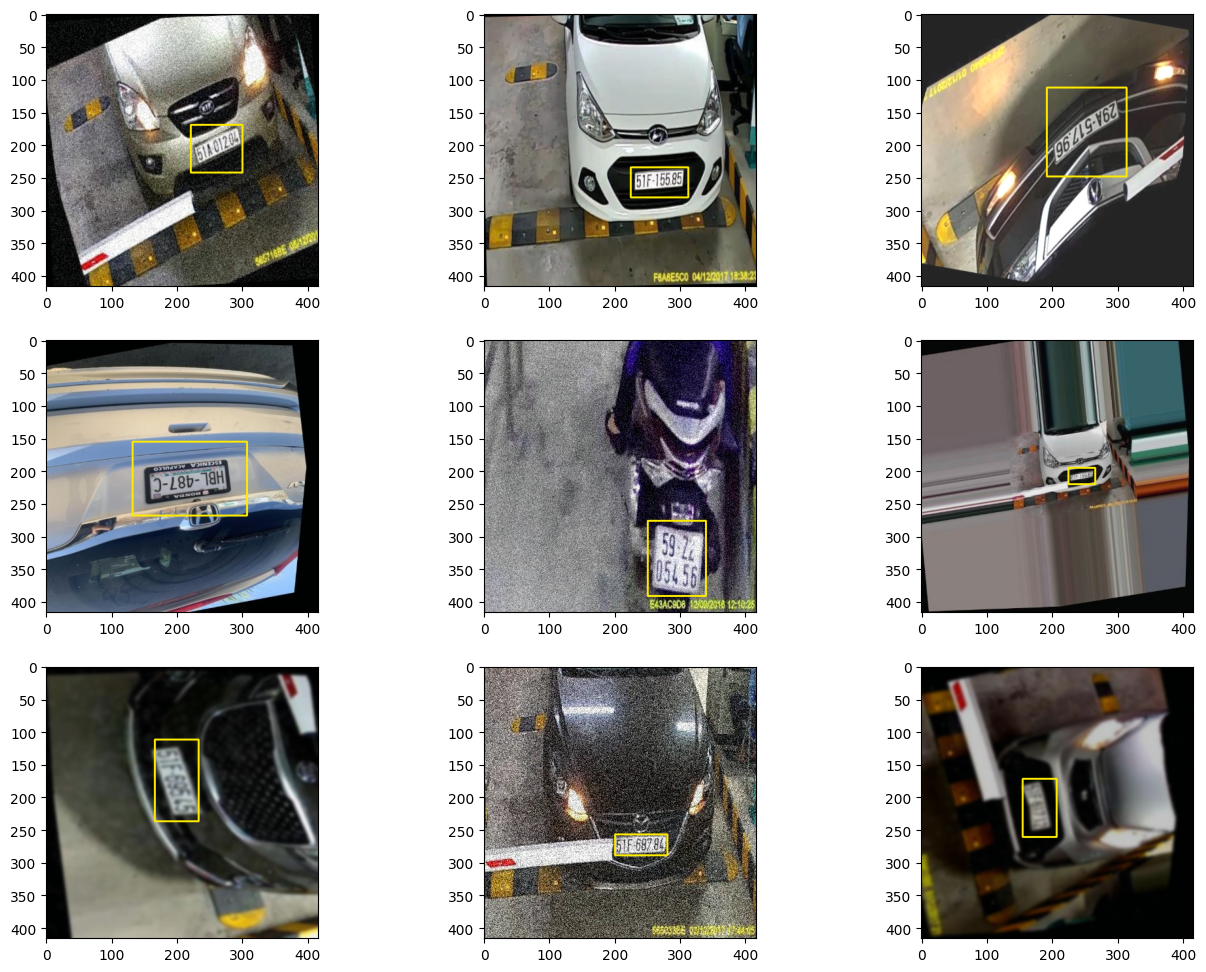

In [18]:
# Display images and labels
sample_idxes = torch.randperm(len(train_dataloader.dataset))[:10]
example_images = [train_dataset[idx][0] for idx in sample_idxes]
example_labels = [train_dataset[idx][1] for idx in sample_idxes]

display_images_and_targets(example_images, example_labels)